In [165]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
from pandas import Timestamp
import gpflow
from gpflow.utilities import print_summary
from gpflow import set_trainable
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta
from gpflow.config import default_float
import math

#### Functions to use

In [166]:
def transform_time(arr):
    new_arr = np.zeros([0, 2])
    for time in arr:
        hour = Timestamp.fromtimestamp(time*3600).hour
        new_time1 = round(math.cos(2*math.pi*hour/24), 2)
        new_time2 = round(math.sin(2*math.pi*hour/24), 2)
        new_arr = np.r_[new_arr,[[new_time1, new_time2]]]
    return new_arr

In [167]:
def transform_road_distance(arr):
    new_arr = np.zeros([0,1])
    for dist in arr:
        new_elem = math.log(dist)
        new_arr = np.append(new_arr, new_elem)
    return new_arr

#### Creating the training datasets for the four models to be compared

In [168]:
def read_pickle(filepath):
    d = pickle.load(open(filepath,'rb'))
    X = d['X']
    Y = d['Y']
    keep = ~np.isnan(Y[:,0]) #remove nans from data...
    Yset = Y[keep,:]
    Xset = X[keep,:]
    return X, Y, Xset, Yset

In [169]:
X, Y, Xset, Yset = read_pickle('kampala_with_distance_population_24_09_20.p')

In [170]:
#X training dataset with long, lat, road distance, population density and time
Xset_pop = Xset
Xset_pop[0, :]

array([3.2610756e+01, 3.6020900e-01, 1.7460000e+01, 4.6370800e+03,
       4.4454400e+05])

In [171]:
# X training dataset with long, lat, road distance and time
Xset_rd = np.delete(Xset, 3, 1)
Xset_rd[0, :]

array([3.2610756e+01, 3.6020900e-01, 1.7460000e+01, 4.4454400e+05])

In [172]:
#X training dataset with long, lat and time
Xset_basic = np.delete(Xset_rd, 2, 1)
Xset_basic[0, :]

array([3.2610756e+01, 3.6020900e-01, 4.4454400e+05])

In [173]:
#X training set with long, lat, population density, created_at, transformed distance and time of day inputs
Xset_transform = Xset
Xset_transform = np.c_[Xset_transform, transform_road_distance(Xset_transform[:, 2])]
Xset_transform = np.delete(Xset_transform, 2, 1)
Xset_transform = np.c_[Xset_transform, transform_time(Xset_transform[:, 3])]
Xset_transform[0, :]

array([ 3.26107560e+01,  3.60209000e-01,  4.63708000e+03,  4.44544000e+05,
        2.85991255e+00,  2.60000000e-01, -9.70000000e-01])

#### Defining the kernels for the models to be developed

In [174]:
basic_kernel = gpflow.kernels.RBF(lengthscales=[0.08, 0.08, 1.]) + gpflow.kernels.Bias()
road_kernel = gpflow.kernels.RBF(lengthscales=[0.08, 0.08, 100., 1.]) + gpflow.kernels.Bias()
popn_road_kernel = gpflow.kernels.RBF(lengthscales=[0.08, 0.08, 100., 1000., 1.]) + gpflow.kernels.Bias()
transform_kernel =gpflow.kernels.RBF(lengthscales=[0.08, 0.08, 1000, 1., 0.3, 0.2, 0.2 ]) +gpflow.kernels.Bias()

#### Cross-validation Function

In [175]:
def cross_validation(X, Y, long, lat, kern):
    '''
    Performs cross validation by removing a specific location's data from the dataset
    '''    
    location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))
    try:
        #Removing location's data from dataset
        Xset = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
        Yset = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
        
        #Creating the training set
        Xtraining = Xset[::2,:]
        Ytraining = Yset[::2,:]
    
        #creating test dataset
        Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
        Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
    
        #training the model
        m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=kern, mean_function=None)
        set_trainable(m.kernel.kernels[0].lengthscales, False) 
    
        #model optimization
        opt = gpflow.optimizers.Scipy()

        def objective_closure():
             return - m.log_marginal_likelihood()

        opt_logs = opt.minimize(objective_closure, m.trainable_variables, options=dict(maxiter=100))
    
        #Making predictions
        mean, var = m.predict_f(Xtest)
    
        #CalculatiNG RMSE and appending to list
        rmse = sqrt(mean_squared_error(Ytest, mean.numpy()))
        return rmse, mean.numpy(), Xtest, Ytest
    except:
        print('An exception occured')

In [176]:
f = lambda time: Timestamp.fromtimestamp(time*3600)
f2 = np.vectorize(f)

In [1]:
def plot_results(Xtest, dataset1, dataset2=None, dataset3=None, dataset4=None, dataset5=None, title='A title', filename='default.png'):
    '''
    Plots results of the differecnt modela dn the actual PM 2.5 concentration
    '''
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.xlim(f2(Xtest[:,2]).min()-timedelta(hours=1), f2(Xtest[:,2]).max()+timedelta(hours=1))
    plt.ylim(10,200)
    plt.plot(f2(Xtest[:, 2]), dataset1, label='Actual')
    if dataset2 is not None:
        plt.plot(f2(Xtest[:, 2]), dataset2, label='Basic')
    if dataset3 is not None:
        plt.plot(f2(Xtest[:, 2]), dataset3, label='with road distance')
    if dataset4 is not None:
        plt.plot(f2(Xtest[:, 2]), dataset4, label='with road distance and population density')
    if dataset5 is not None:
        plt.plot(f2(Xtest[:, 2]), dataset5, label='with time of day and transformed road distance')
    plt.legend(loc='best')
    plt.savefig(filename) 
    plt.show()

In [178]:
longs = [X[:,0][index] for index in sorted(np.unique(X[:,0], return_index=True)[1])]
lats = [X[:,1][index] for index in sorted(np.unique(X[:,1], return_index=True)[1])]

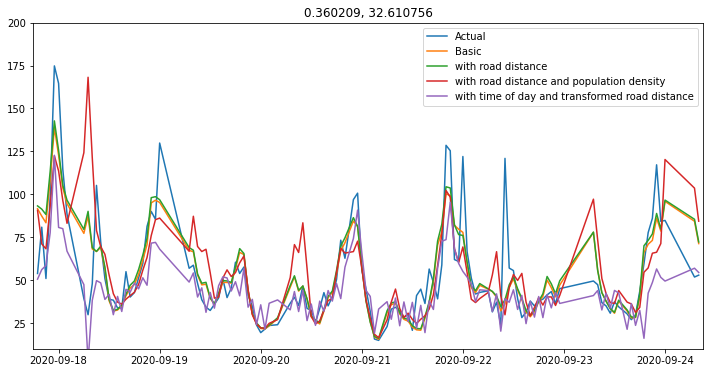

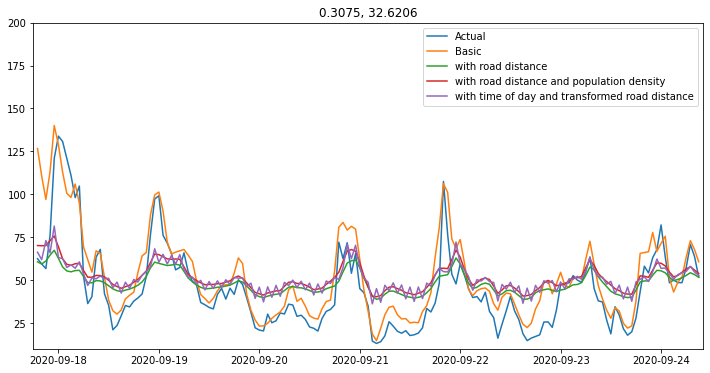

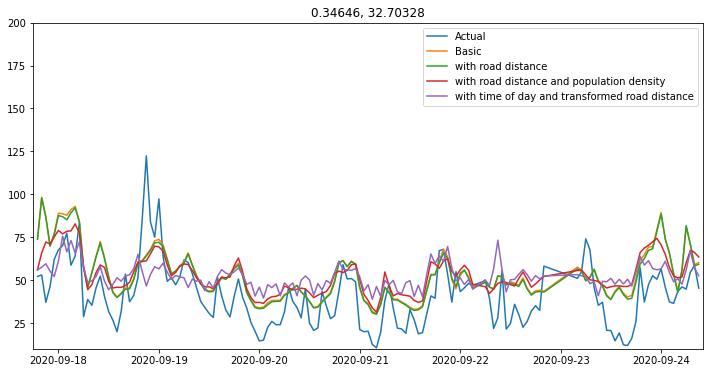

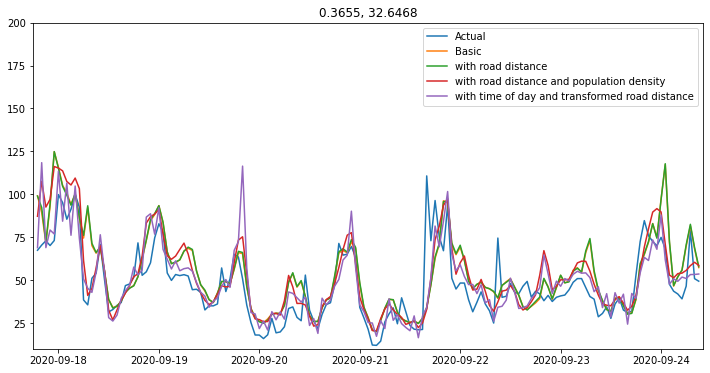

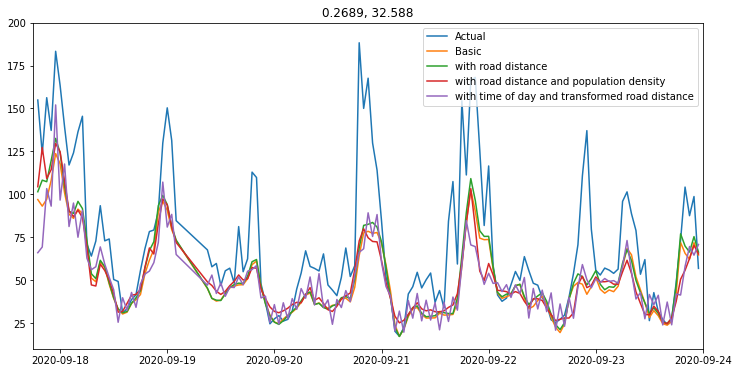

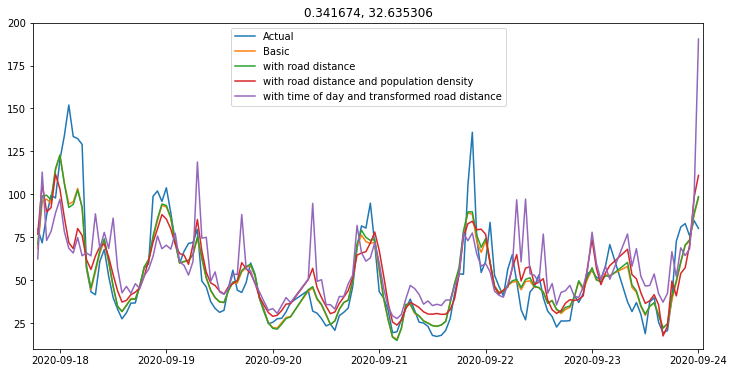

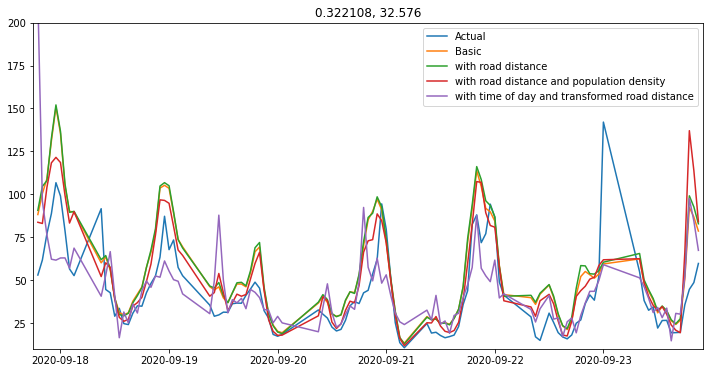

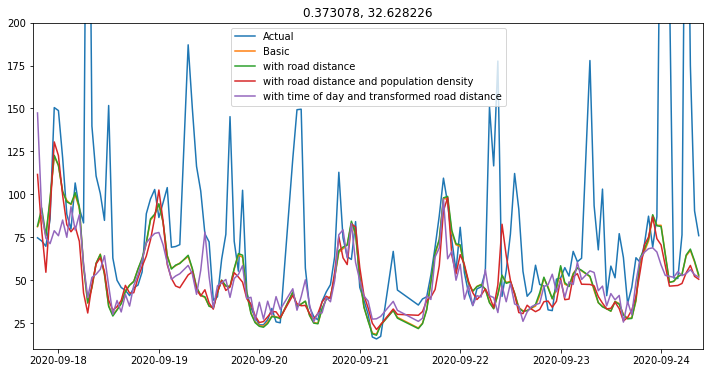

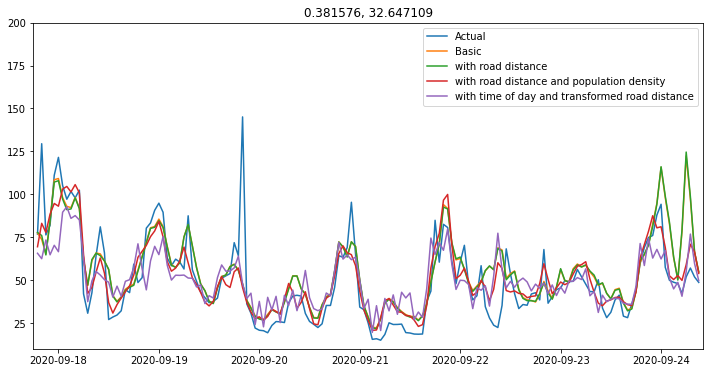

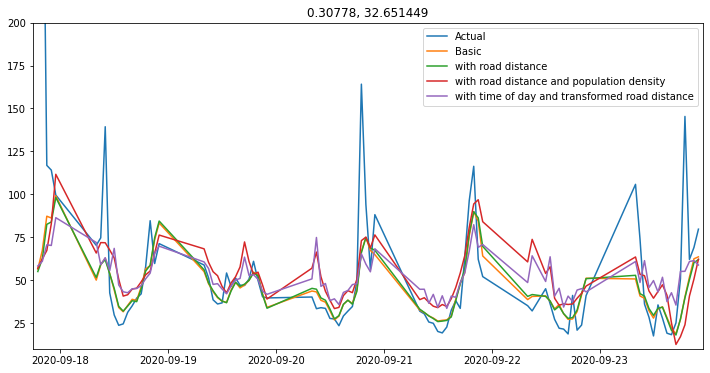

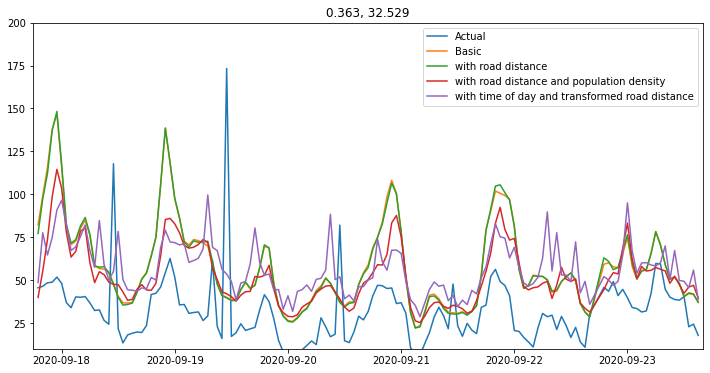

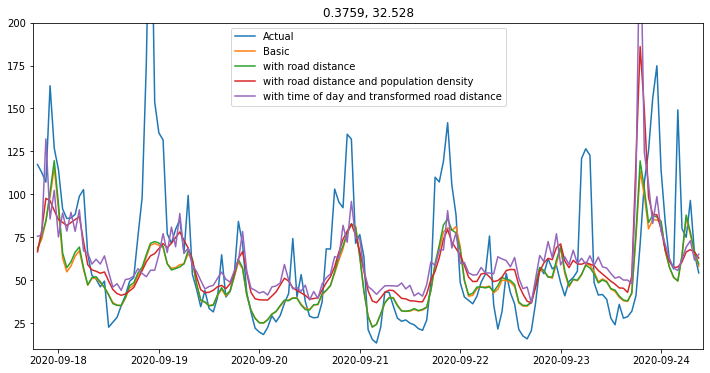

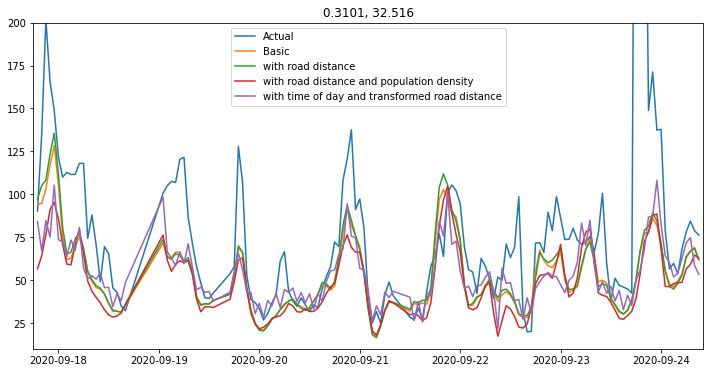

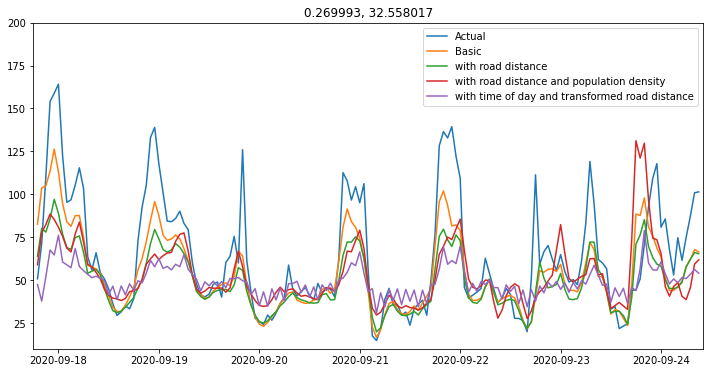

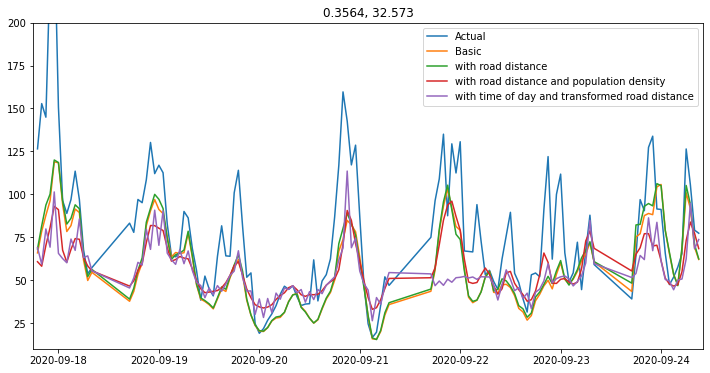

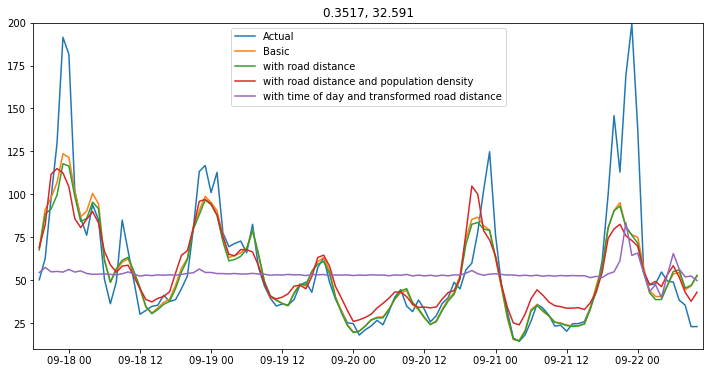

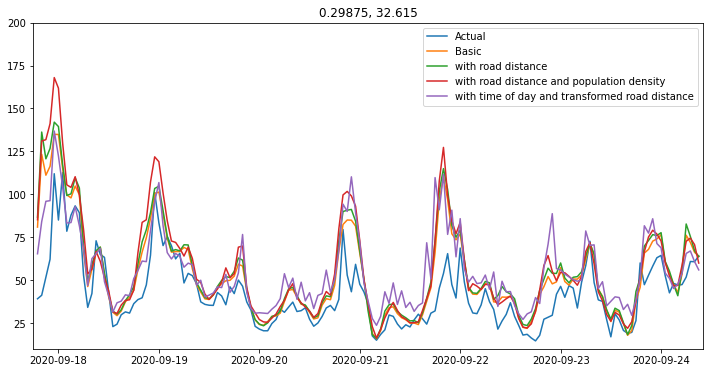

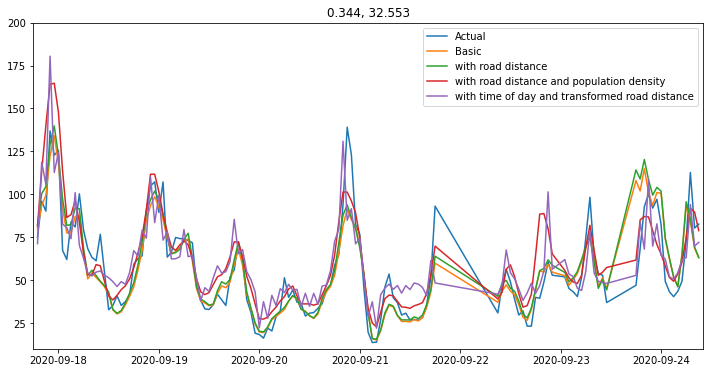

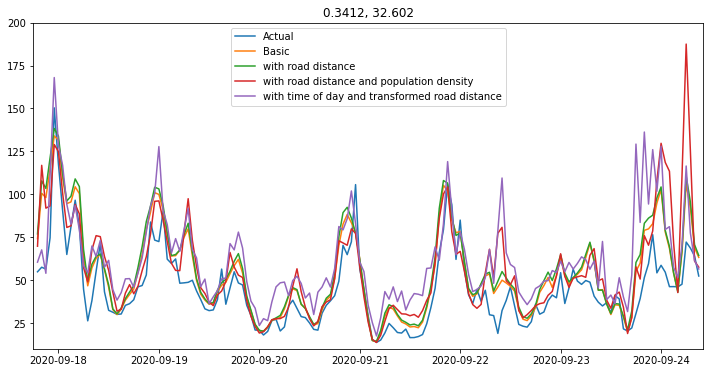

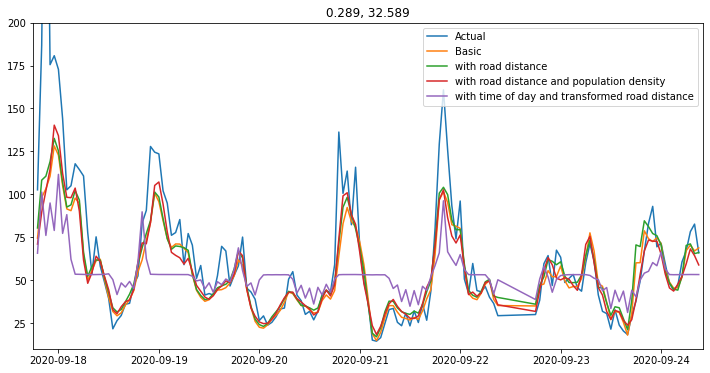

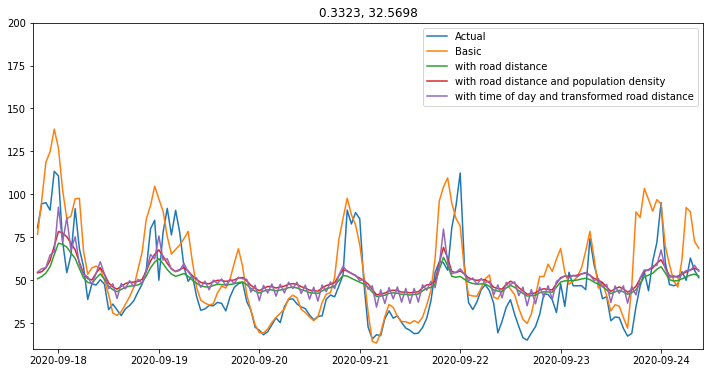

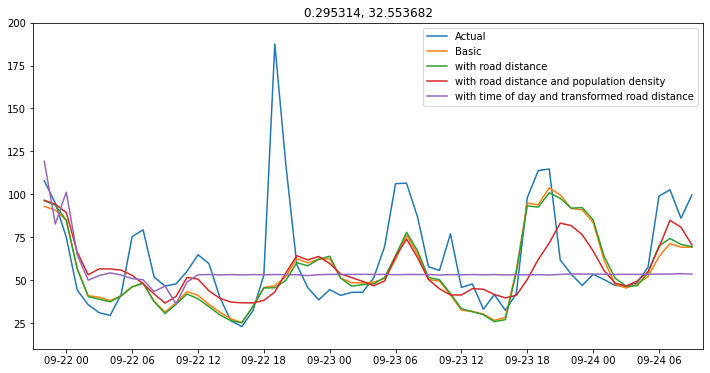

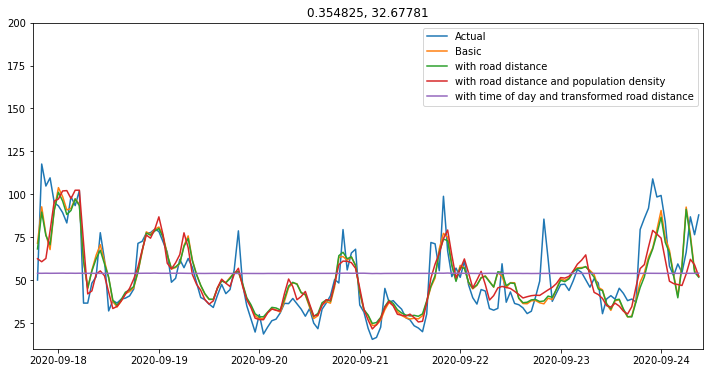

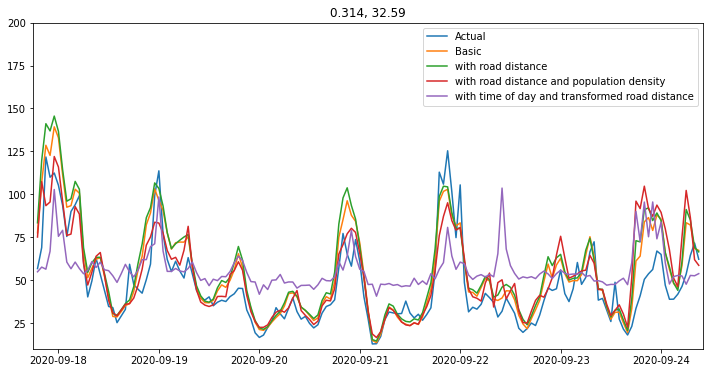

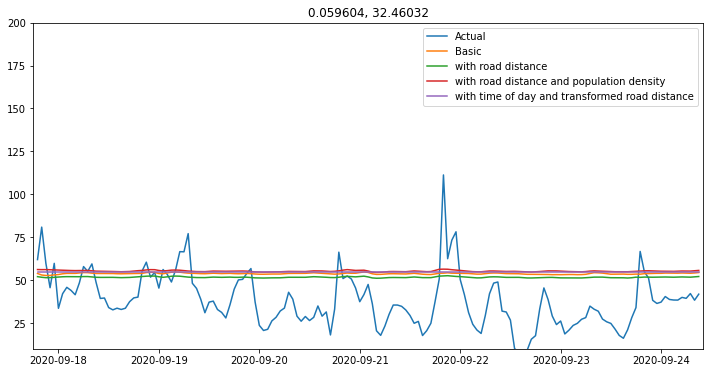

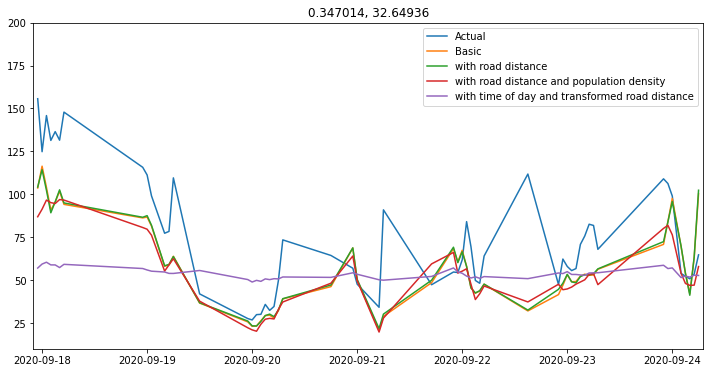

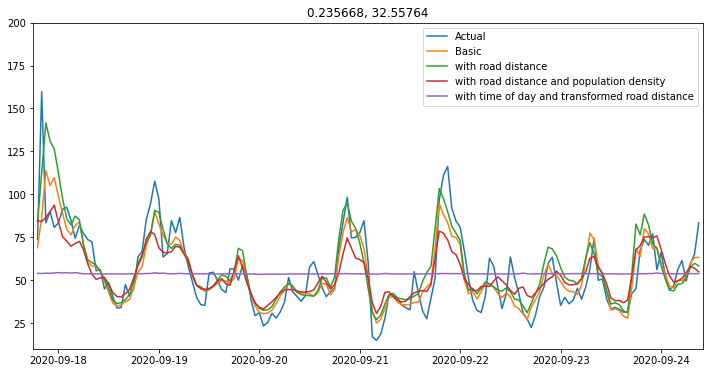

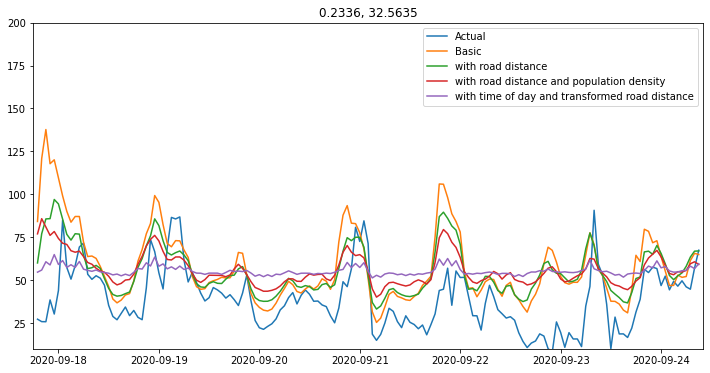

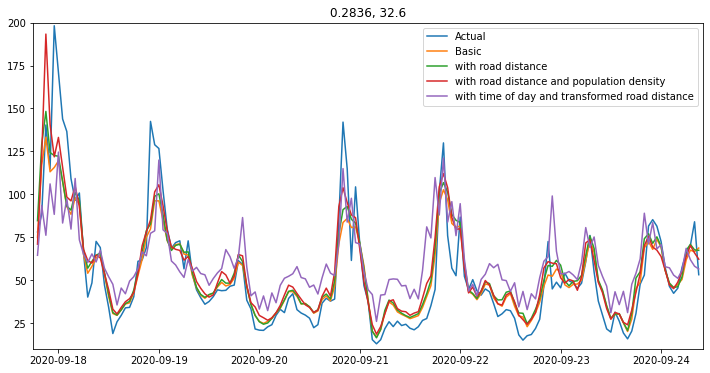

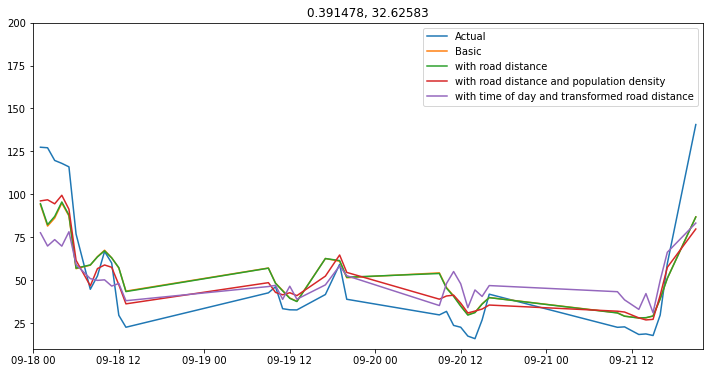

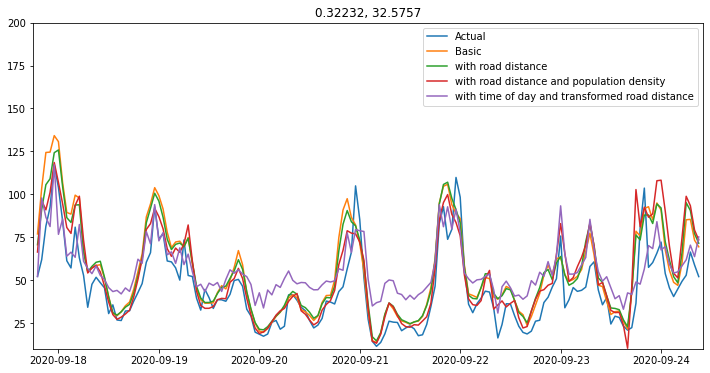

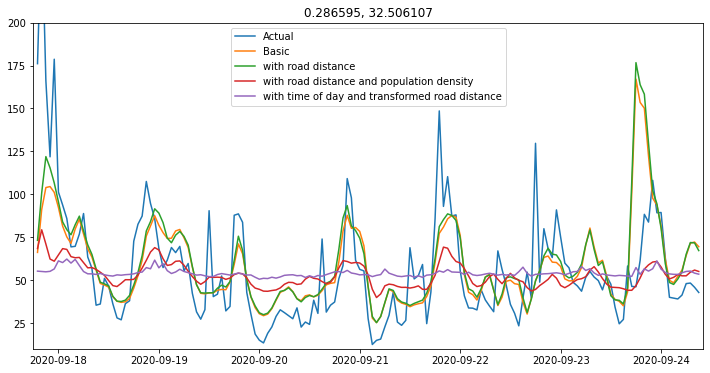

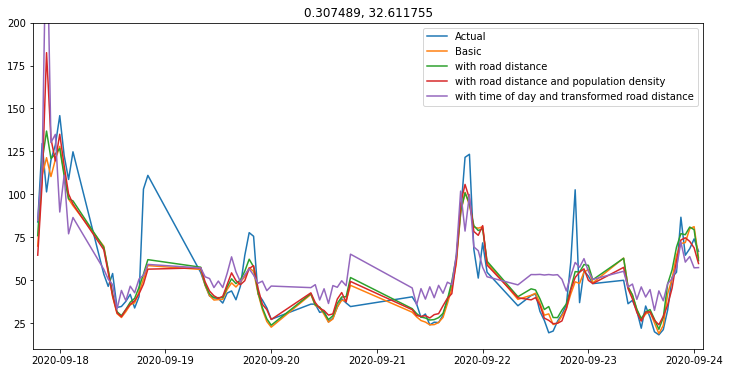

In [179]:
basic_rmses= []
rd_rmses= []
popn_rmses= []
tf_rmses=[]
for i in range(len(longs)):
    rmse_basic, preds_basic, Xtest_basic, Ytest_basic = cross_validation(Xset_basic, Yset, longs[i], lats[i], basic_kernel)
    rmse_rd, preds_rd, Xtest_rd, Ytest_rd = cross_validation(Xset_rd, Yset, longs[i], lats[i], road_kernel)
    rmse_popn, preds_popn, Xtest_popn, Ytest_popn = cross_validation(Xset_pop, Yset, longs[i], lats[i], popn_road_kernel)
    rmse_tf, preds_tf, Xtest_tf, Ytest_tf = cross_validation(Xset_transform, Yset, longs[i], lats[i], transform_kernel)
    basic_rmses.append(rmse_basic)
    rd_rmses.append(rmse_rd)
    popn_rmses.append(rmse_popn)
    tf_rmses.append(rmse_tf)
    
    plot_results(Xtest_basic, #Xtest
                 Ytest_basic, #dataset1
                 preds_basic, #dataset2
                 preds_rd, #dataset3
                 preds_popn, #dataset4
                 preds_tf, #dataset5
                 title=str(lats[i])+', '+str(longs[i]),
                 #filename = 'multi_model_cv_plots/'+str(i)+'.png'
                 filename = 'new_multi_model_cv_plots/'+str(i)+'.png'
                )
    

In [180]:
min(basic_rmses), min(rd_rmses), min(popn_rmses), min(tf_rmses) 

(11.663805156440606, 12.376166933104447, 12.70498141864832, 13.662493150826755)

In [181]:
max(basic_rmses), max(rd_rmses), max(popn_rmses), max(tf_rmses)

(65.59505673644584, 65.57852004924956, 67.33152425193929, 67.61418668563287)

In [182]:
tf_rmses==popn_rmses

False

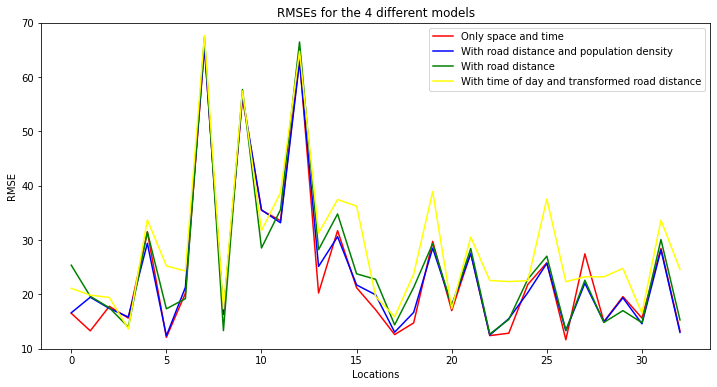

In [185]:
plt.figure(figsize=(12,6))
plt.title('RMSEs for the 4 different models')
plt.ylim(10,70)
plt.xlabel('Locations')
plt.ylabel('RMSE')
plt.plot(basic_rmses, label='Only space and time', color ='red')  
plt.plot(rd_rmses, label='With road distance and population density', color='blue')
plt.plot(popn_rmses, label='With road distance', color='green')
plt.plot(tf_rmses, label='With time of day and transformed road distance', color='yellow')
plt.legend(loc='best')
plt.savefig('new_multi_model_cv_plots/RMSEs.png') 
plt.show()